# Анализ тарифов сотовой связи

**Цель** - *исследовать набор данных о двух тарифах компании `Megaline` и предложить возможные варианты улучшения продукта.*

**Ход работы:**
1. *Загрузка данных*
2. *Предобработка данных (дубликаты, пропущенные значения, аномалии, выбивающиеся значения)*
3. *Категоризация данных по различным параметрам для дальнейшего анализа*
4. *Анализ данных (статистический и аналитическиий)*
5. *Проверка гипотез*

### 1. Exploring the data!


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats as st

In [2]:
try:
    calls = pd.read_csv("calls.csv")
    internet = pd.read_csv("internet.csv")
    messages = pd.read_csv("messages.csv")
    tariffs = pd.read_csv("tariffs.csv")
    users = pd.read_csv("users.csv")
except:
    calls = pd.read_csv("/datasets/calls.csv")
    internet = pd.read_csv("/datasets/internet.csv")
    messages = pd.read_csv("/datasets/messages.csv")
    tariffs = pd.read_csv("/datasets/tariffs.csv")
    users = pd.read_csv("/datasets/users.csv")
# this is done to run the project both on local machine and online in another directory

Создадим список с нашими датасетами.

In [3]:
datasets = [calls, internet, messages, tariffs, users]

In [4]:
for dataset in datasets:
    print(dataset.columns, dataset.shape, sep = '\n', end = '\n\n')

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')
(202607, 4)

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')
(149396, 5)

Index(['id', 'message_date', 'user_id'], dtype='object')
(123036, 3)

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')
(2, 8)

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
(500, 8)



### 2. Preprocessing

**2.1. Обработаем колонки во всех датасетах.**

Обработка колонок в **`calls`**

In [5]:
calls.dtypes

id            object
call_date     object
duration     float64
user_id        int64
dtype: object

In [6]:
calls['id'] = calls['id'].astype('int64')
calls['call_date'] = pd.to_datetime(calls['call_date'])

Обработка колонок в **`internet`**

In [7]:
internet.dtypes

Unnamed: 0        int64
id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

In [8]:
internet = internet.drop('Unnamed: 0', axis = 1)
internet['id'] = internet['id'].astype('int64')
internet['session_date'] = pd.to_datetime(internet['session_date'])

Обработка колонок в **`messages`**

In [9]:
messages.dtypes

id              object
message_date    object
user_id          int64
dtype: object

In [10]:
messages['id'] = messages['id'].astype('int64')
messages['message_date'] = pd.to_datetime(messages['message_date'])

Обработка колонок в **`users`**

In [11]:
users.dtypes

user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

**2.2. Избавимся от дубликатов**

In [13]:
duplicates = []
for dataset in datasets:
    duplicates.append(dataset.duplicated().sum())
    
print(duplicates)

[0, 0, 0, 0, 0]


Дубликаты отсутствуют.

**2.3. Посмотрим на пропущенные значения**

In [14]:
nans = []
for dataset in datasets:
    for column in dataset:
        nans.append(dataset[column].isna().sum())
    print(nans)
    nans.clear()

[0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 462, 0, 0, 0, 0, 0]


Есть пропуски в датасете `users` в `churndate`, но `churndate` обозначает момент окончания тарифа. Если значение пропущено => тариф еще действовал на момент выгрузки данных. Можно сделать вывод, что в данных нет пропущенных значений.

**2.4. Исследуем аномальные и другие выбивающиеся численные значения. Посмотрим на распределения.**

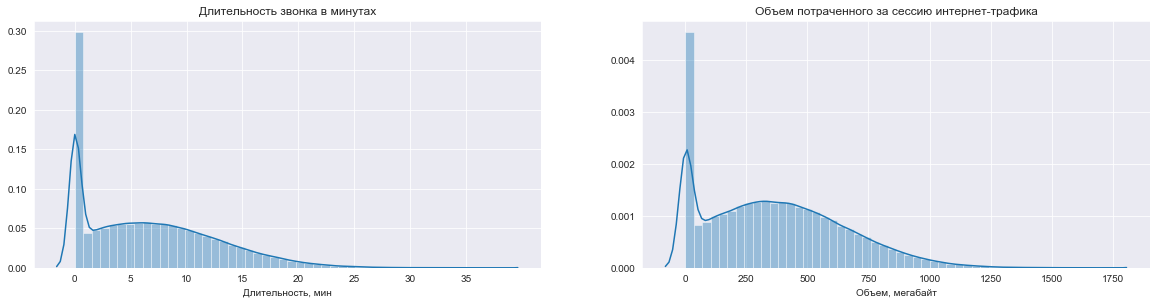

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
plt.title('Длительность звонка в минутах')
sns.distplot(calls['duration'])
plt.xlabel('Длительность, мин')
plt.xticks(range(0, 40, 5))

plt.subplot(2,2,2)
plt.title('Объем потраченного за сессию интернет-трафика')
sns.distplot(internet['mb_used'])
plt.xlabel('Объем, мегабайт')

plt.show()

0 минут в длительности звонка означает, что это был пропущенный вызов => не будем избавляться от этих значений.

0 мб значит, что человек не пользовался интернетом, поэтому мы можем избавиться от этих строк.

In [16]:
internet = internet[internet['mb_used'] != 0]

Теперь посмотрим на распределение возраста.

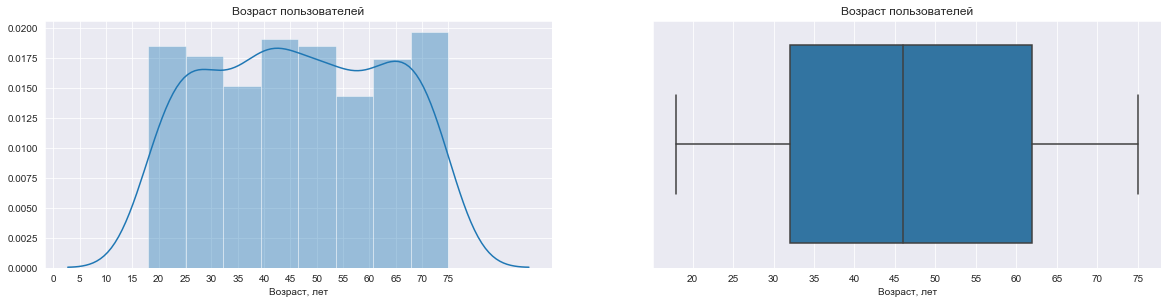

In [17]:
plt.figure(figsize = (20,10))


plt.subplot(2,2,1)
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.xticks(range(0, 80, 5))
sns.distplot(users['age'])
plt.xlabel('Возраст, лет')

plt.subplot(2,2,2)
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.xticks(range(0, 80, 5))
sns.boxplot(users['age'])
plt.xlabel('Возраст, лет')


plt.show()

Можно сделать вывод, что практически люди всех возрастов одинаково часто пользуются услугами компании Megaline.

**2.5. Компания Megaline округляет секунды до минут за каждую сессию. Реализуем это на нашей таблице.**

In [18]:
calls['duration'] = np.ceil(calls['duration']).astype('int64')

**2.6. Добавим новые столбцы c месяцами.**

In [19]:
# adding month column

calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

**2.7. Посчитаем следующие новые метрики.**

- Количество сделанных звонков и израсходованных минут разговора по месяцам
- Количество отправленных сообщений по месяцам
- Oбъем израсходованного интернет-трафика по месяцам
- Помесячную выручку с каждого пользователя

**2.7.1.** Подсчет сделанных звонков и израсходованных минут разговора по месяцам.

In [20]:
calls_new = calls.groupby(['user_id', 'month']).agg(calls_duration =  ('duration', 'sum'),
                                                    calls_number = ('id', 'count')).reset_index()
calls_new.sample(10)

,user_id,month,calls_duration,calls_number
2604,1410,11,555,69
1244,1197,6,220,35
1428,1226,12,158,19
1074,1172,11,537,65
2167,1345,12,267,35
840,1135,1,90,9
930,1149,10,261,35
2727,1429,2,240,37
3064,1480,7,471,67
215,1033,10,375,55


**2.7.2.** Подсчет количества отправленных сообщений по месяцам.

In [21]:
messages_new = messages.groupby(['user_id', 'month']).agg(messages_number = ('id', 'count')).reset_index()
messages_new.sample(10)

,user_id,month,messages_number
13,1002,11,16
2591,1477,8,63
1159,1221,9,19
274,1052,11,106
397,1072,6,22
953,1180,3,16
4,1000,9,57
1262,1245,9,65
1064,1200,8,49
1368,1267,12,12


**2.7.3.** Подсчет израсходованного интернет трафика по месяцам.

In [22]:
internet_new = internet.groupby(['user_id', 'month']).agg(mb_used_month = ('mb_used', 'sum')).reset_index()
internet_new['gb_used_month'] = np.ceil(internet_new['mb_used_month'] / 1024).astype('int64')

internet_new = internet_new.drop(columns = ['mb_used_month'], axis = 1)

internet_new.sample(10)

,user_id,month,gb_used_month
953,1150,12,17
1458,1228,5,22
2073,1328,10,22
1353,1211,10,19
1963,1310,12,19
2467,1388,11,25
1374,1216,11,5
2955,1463,12,26
394,1063,6,21
1658,1263,5,18


**2.7.4.** Подсчет помесячной выручки с каждого пользователя.

Объединим колонки в один общий датасет для расчета выручки.

In [23]:
data = calls_new.merge(internet_new, how = 'outer', on = ['user_id', 'month'])
data = data.merge(messages_new, how = 'outer', on = ['user_id', 'month'])
data = data.merge(users, how = 'outer', on = ['user_id'])
data = data.merge(tariffs, how = 'outer', left_on = ['tariff'], right_on = ['tariff_name'])

data = data.drop(columns = ['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name'])

In [24]:
data = data.rename(columns = {'mb_per_month_included' : 'gb_per_month_included'})
data['gb_per_month_included'] = (data['gb_per_month_included'] / 1024).astype('int64')

Напишем функцию для расчета прибыли и применим ее к таблице.

In [25]:
def revenue(row):
    fare = row.rub_monthly_fee
    if row.messages_number > row.messages_included:
        fare += (row.messages_number - row.messages_included)*row.rub_per_message
    if (row.calls_duration > row.minutes_included):
        fare += (row.calls_duration - row.minutes_included)*row.rub_per_minute
    if (row.gb_used_month > row.gb_per_month_included):
        fare += (row.gb_used_month - row.gb_per_month_included)*row.rub_per_gb
    return fare

Добавим новый столбец `full_cost` и применим функцию для расчета прибыли.

In [26]:
data['full_cost'] = data.apply(revenue, axis = 1).astype('int64')

Удалим ненужные для дальнейшего анализа столбцы c описанием тарифов.

In [27]:
data = data.drop(columns = ['messages_included',
                       'gb_per_month_included',
                       'minutes_included',
                       'rub_monthly_fee',
                       'rub_per_gb',
                       'rub_per_message',
                       'rub_per_minute'])

In [28]:
data.sample(10)

,user_id,month,calls_duration,calls_number,gb_used_month,messages_number,tariff,full_cost
1317,1068,8.0,622.0,84.0,25.0,19.0,smart,2916
1610,1135,11.0,427.0,58.0,24.0,27.0,smart,2350
2711,1393,6.0,518.0,72.0,12.0,51.0,smart,607
1875,1189,2.0,550.0,75.0,22.0,20.0,smart,2100
113,1078,12.0,1273.0,177.0,26.0,NaN,ultra,1950
917,1471,6.0,650.0,111.0,9.0,94.0,ultra,1950
1921,1199,10.0,511.0,78.0,9.0,72.0,smart,649
630,1356,7.0,850.0,114.0,30.0,144.0,ultra,1950
1763,1171,12.0,489.0,73.0,14.0,90.0,smart,670
1010,1006,5.0,370.0,56.0,13.0,NaN,smart,550


Так как мы объединяли таблицы методом с помощью `outer`, то образовались пропуски в столбцах, могло получиться так, что человек использует только сообщения и интернет, а звонками не пользуется, или наоборот, поэтому заполним пропущенные значения нулями.

In [29]:
cnt= 0
for column in data:
    cnt +=1
    print(f"{cnt}. {column} | amount of NaNs - {data[column].isna().sum()}")

1. user_id | amount of NaNs - 0
2. month | amount of NaNs - 2
3. calls_duration | amount of NaNs - 42
4. calls_number | amount of NaNs - 42
5. gb_used_month | amount of NaNs - 15
6. messages_number | amount of NaNs - 499
7. tariff | amount of NaNs - 0
8. full_cost | amount of NaNs - 0


1. `month` - заполним модой, всего лишь 2 пропуска, поэтому это не критично
2. `calls_duration` и `calls_number` - заполним нулями
3. `gb_used_month` - заполним нулями
4. `messages_number` - заполним нулями

In [30]:
data['month'] = data['month'].fillna(data['month'].mode()[0])

columns =  ['calls_duration', 'calls_number', 'gb_used_month', 'messages_number'] # needed columns to fill NaNs with zero
for column in columns:
    data[column] = data[column].fillna(0)

### 3. Data Analysis

Проведем анализ и сделаем выводы, прочитая следующие характеристики:
- Сколько минут разговора требуется пользователям каждого тарифа в месяц.
- Сколько сообщений требуется пользователям каждого тарифа в месяц.
- Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

#### 3.1. Распределение количества минут разговора пользователей в месяц. Посмотрим на детальную статистику с помощью метода `.describe()` и сделаем окончательные выводы. Посчитаем дисперсию и среднеквадратическое отклонение.

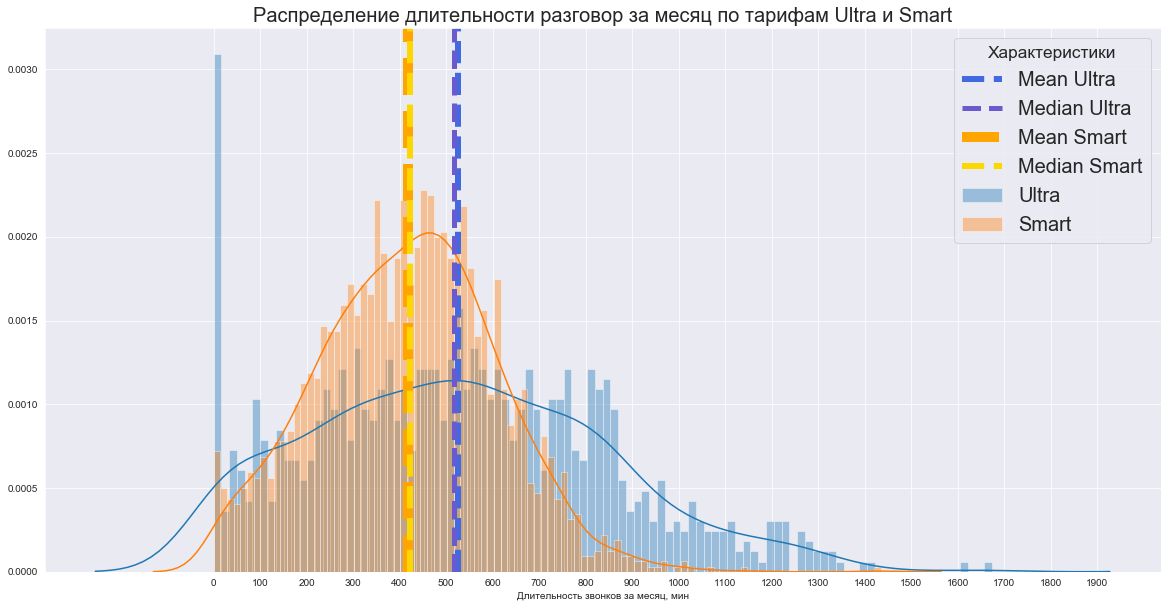

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,417.747534,190.476754,0.0,13.58,282.0,421.5,545.00,872.71,1435.0,36281.393836
ultra,986.0,526.089249,317.887549,0.0,0.00,282.5,518.0,751.75,1291.05,1673.0,101052.493549


In [34]:
plt.figure(figsize = (20,10))

#displots for tariffs
sns.distplot(data[data['tariff'] == 'ultra']['calls_duration'], bins = 100, label = 'Ultra')
sns.distplot(data[data['tariff'] == 'smart']['calls_duration'], bins = 100, label = 'Smart')
plt.title('Распределение длительности разговор за месяц по тарифам Ultra и Smart', size = 20)
plt.xlabel('Длительность звонков за месяц, мин')
plt.xticks(range(0, 2000, 100))

# mean line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['calls_duration'].mean(), color='royalblue',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 6,
                                                                        label = 'Mean Ultra')
# median line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['calls_duration'].median(), color='slateblue',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 5,
                                                                        label = 'Median Ultra')

# mean line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['calls_duration'].mean(), color='orange',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 10,
                                                                        label = 'Mean Smart')

# median line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['calls_duration'].median(), color='gold',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 6,
                                                                        label = 'Median Smart')

plt.legend(prop = {'size' : 20}, title = 'Характеристики', title_fontsize = 'xx-large')
plt.savefig('output1.png')

plt.show()

calls_desc = data.groupby('tariff')['calls_duration'].describe(percentiles = [.01,.25,.75,.99])

calls_desc['var'] = [np.var(data.groupby('tariff')['calls_duration'].get_group('smart'), ddof=1),
                     np.var(data.groupby('tariff')['calls_duration'].get_group('ultra'), ddof=1)]

calls_desc



**Общие выводы:**
1. Можно увидеть, что среднее и медианы в каждом тарифе примерно одинаковые, значит у нас почти нет выбросов, которые сильно бы повлияли на среднее.
2. В целом, обе гистограммы напоминают стандартное распределение, только `smart` оно выражено более явно, чем `ultra`.
3. В среднем пользователи тарифа `smart` тратят на 100 больше минут в месяц, чем `ultra`. При этом стандартное отклонение у `smart` гораздо меньше, чем у `ultra`.

**Выводы по тарифу `smart`:**
- Им пользуются почти в 2 раза больше людей, чем `ultrа`.
- Медиана и средние одинаковые (~420).
- Почти все пользователи используют не больше 870 минут за месяц.
- Скорее всего им пользуются обычные люди, которым не требуется большого количества минут для разговоров.

**Выводы по тарифу `ultra`:**
- Менее популярный, но люди, пользующиеся им, тратят намного больше минут в месяц, особенно это видно на промежутке [700;1300].
- Можно заметить, что некоторые пользователи тарифа `ultra` вообще не пользуются звонками, скорее всего они покупают этот тариф ради большого количества интернета. Проверим это на следующей гистограмме по интернету.
- Выбросы гораздо менее выражены, чем на `smart`.
- Медиана и среднее одинаковые (~520).

#### 3.2.Распределение количества сообщений, которые написал каждый пользователей за месяц.

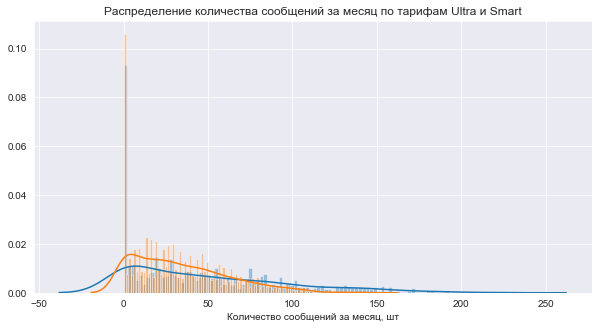

In [35]:
plt.figure(figsize = (10,5))

#displots for tariffs
sns.distplot(data[data['tariff'] == 'ultra']['messages_number'], bins = 100, label = 'Ultra')
sns.distplot(data[data['tariff'] == 'smart']['messages_number'], bins = 100, label = 'Smart')
plt.title('Распределение количества сообщений за месяц по тарифам Ultra и Smart')
plt.xlabel('Количество сообщений за месяц, шт')

plt.show()

#### Вывод:
Видим, что очень большое количество людей, которые не пользуются сообщениями вообще, это логично, ведь все привыкли использовать интернет для этого, уберем людей, которые не пишут сообщения из выборки и построим более наглядную гистограмму.

#### 3.2. Распределение количества сообщений, которые написал каждый пользователей за месяц
*(без учёта людей, которые не пишут сообщения)*

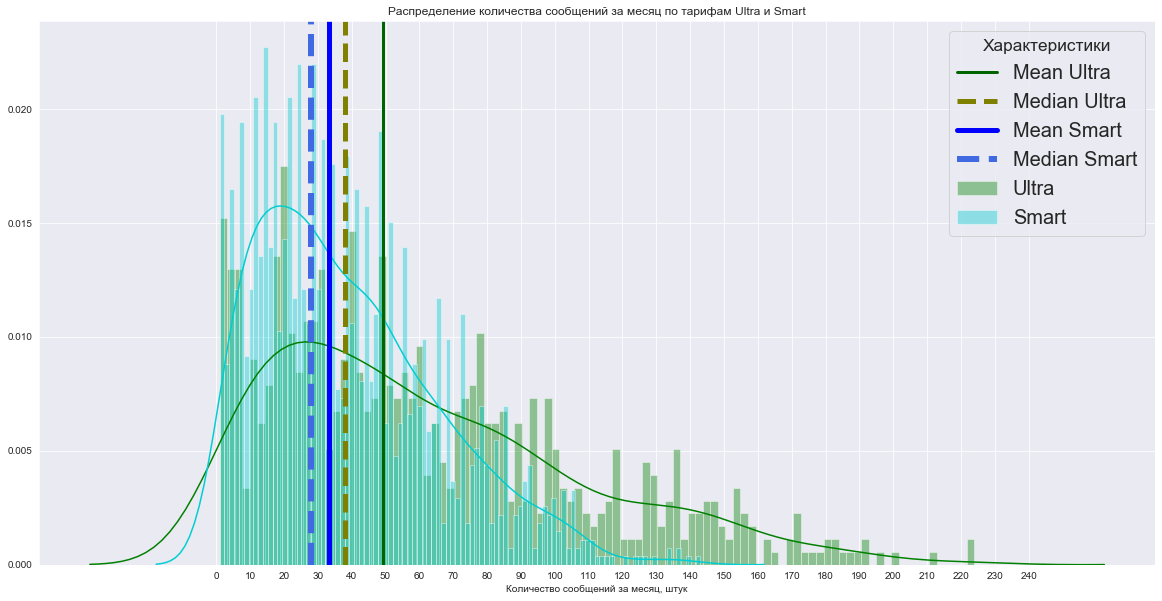

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,33.369058,28.230396,0.0,0.0,10.0,28.0,51.00,108.0,143.0,717.594201
ultra,986.0,49.313387,47.806040,0.0,0.0,6.0,38.0,78.75,183.3,224.0,2109.659183


In [36]:
plt.figure(figsize = (20,10))

#displots for tariffs
sns.distplot(data[(data['tariff'] == 'ultra') & (data['messages_number'] != 0)]['messages_number'],
                                                                         bins = 100, label = 'Ultra', color = 'green')

sns.distplot(data[(data['tariff'] == 'smart') & (data['messages_number'] != 0)]['messages_number'],
                                                                         bins = 100, label = 'Smart', color = 'darkturquoise')

plt.title('Распределение количества сообщений за месяц по тарифам Ultra и Smart')
plt.xlabel('Количество сообщений за месяц, штук')
plt.xticks(range(0,250,10))

# mean line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['messages_number'].mean(), color='darkgreen',
                                                                        linewidth = 3,
                                                                        label = 'Mean Ultra')
# median line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['messages_number'].median(), color='olive',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 5,
                                                                        label = 'Median Ultra')

# mean line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['messages_number'].mean(), color='blue',
                                                                        linewidth = 5,
                                                                        label = 'Mean Smart')

# median line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['messages_number'].median(), color='royalblue',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 6,
                                                                        label = 'Median Smart')

plt.legend(prop = {'size' : 20}, title = 'Характеристики', title_fontsize = 'xx-large')

plt.show()

messages_desc = data.groupby('tariff')['messages_number'].describe(percentiles = [.01,.25,.75,.99])

messages_desc['var'] = [np.var(data[data['messages_number'] != 0].groupby('tariff')['messages_number'].get_group('smart'), ddof=1),
                        np.var(data[data['messages_number'] != 0].groupby('tariff')['messages_number'].get_group('ultra'), ddof=1)]

messages_desc

**Выводы**:
1. В обоих случаях гистограмма скошена вправо. Можно открыто пронаблюдать, что с увеличением количества сообщений уменьшается количество людей, которые их пишут.
2. Среднее большее, чем медиана, очевидно, из-за скошенности.
3. Люди, пользующиеся `ultra` тратят немного больше сообщений, чем `smart`, но эта разница не критична.

**Важное замечание**:

*Мы убрали огромное количество значений, где пользователи не пользовались сообщениями вообще в обоих тарифах, можно сделать вывод, что сообщения - это не определяющий фактор при выборе тарифа от слова совсем.*

#### 3.3. Распределение использования интернет-трафика за месяц.

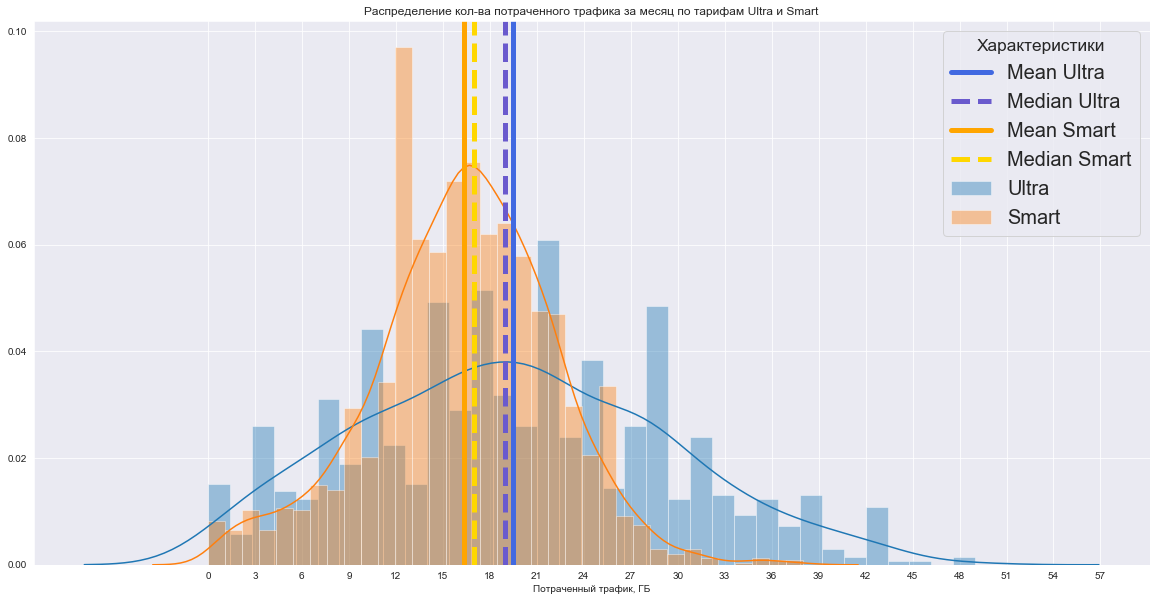

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.0,16.321525,5.756167,0.0,2.0,13.0,17.0,20.0,29.71,38.0,33.133453
ultra,986.0,19.474645,9.868057,0.0,0.0,12.0,19.0,27.0,42.15,49.0,97.378544


In [37]:
plt.figure(figsize = (20,10))

#displots for tariffs
sns.distplot(data[data['tariff'] == 'ultra']['gb_used_month'], bins = 35, label = 'Ultra')
sns.distplot(data[data['tariff'] == 'smart']['gb_used_month'], bins = 35, label = 'Smart')
plt.title('Распределение кол-ва потраченного трафика за месяц по тарифам Ultra и Smart')
plt.xlabel('Потраченный трафик, ГБ')
plt.xticks(range(0,60, 3))

# mean line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['gb_used_month'].mean(), color='royalblue',
                                                                        linewidth = 5,
                                                                        label = 'Mean Ultra')
# median line for ultra
plt.axvline(x=data[data['tariff'] == 'ultra']['gb_used_month'].median(), color='slateblue',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 5,
                                                                        label = 'Median Ultra')

# mean line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['gb_used_month'].mean(), color='orange',
                                                                        linewidth = 5,
                                                                        label = 'Mean Smart')

# median line for smart
plt.axvline(x=data[data['tariff'] == 'smart']['gb_used_month'].median(), color='gold',
                                                                        linestyle = 'dashed', 
                                                                        linewidth = 5,
                                                                        label = 'Median Smart')

plt.legend(prop = {'size' : 20}, title = 'Характеристики', title_fontsize = 'xx-large')

plt.show()

internet_desc = data.groupby('tariff')['gb_used_month'].describe(percentiles = [.01,.25,.75,.99])

internet_desc['var'] = [np.var(data.groupby('tariff')['gb_used_month'].get_group('smart'), ddof=1),
                     np.var(data.groupby('tariff')['gb_used_month'].get_group('ultra'), ddof=1)]

internet_desc

#### Вывод:
1. График тарифа `smart` напоминает типичное нормальное распределение, а `ultra` - распределение Стьюдента.
2. Медианы и средние практически не отличаются, аномальных значений минимум. 
3. Среднеквадратическое отклонение в 2 раза выше в тарифе `ultra` при том, что .50% используют примерно одинаковое кол-во гигабайт в обоих тарифах.

### 4. Hypothesis testing

**Проверим 2 гипотезы:**

1. *Средняя выручка пользователей тарифов `smart` и `ultra` отличаются.*
2. *Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.*

- Гипотезы будем проверять с помощью t-критерия на двух выборках из `data`.
- Оценивать будем по p-value. Уровень значимости зададим 5% или 0.05.

#### 4.1. Гипотеза: средняя выручка пользователей тарифов `smart` и `ultra` отличается.

 - **H₀** - Средняя выручка пользователей тарифов `smart` и `ultra` не отличается.
 - **H₁** - Средняя выручка пользователей тарифов `smart` и `ultra` отличается.

In [1]:
# H0 checking
alpha = 0.05

sample_smart = data.query('tariff == "smart"')['full_cost']
sample_ultra = data.query('tariff == "ultra"')['full_cost']

result = st.ttest_ind(sample_smart, sample_ultra)

print(f"p-value = {result.pvalue}", end = '\n\n')
if result.pvalue < alpha:
    print("H0 gets denied.")
else:
    print("H0 doesn't get denied.")

NameError: name 'data' is not defined

*P-value слишком малó, поэтому мы может **отбросить нулевую гипотезу** и **принять альтернативную H1**, которая заключаетсяв том, что средняя выручка пользователей тарифов **отличается**.*

#### 4.2. Гипотеза: cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

 - **H₀** - Средняя выручка пользователей из Москвы и регионов не отличается.
 - **H₁** - Средняя выручка пользователей из Москвы и регионов отличается.

In [146]:
data = data.merge(users[['city', 'user_id']], how = 'outer', on = 'user_id')
# adding city column in data

In [147]:
#H0 checking

sample_moscow = data.query('city == "Москва"')['full_cost']
sample_other = data.query('city != "Москва"')['full_cost']

result = st.ttest_ind(sample_moscow, sample_other)

print(f"p-value = {result.pvalue}", end = '\n\n')
if result.pvalue < alpha:
    print("H0 gets denied.")
else:
    print("H0 doesn't get denied.")

p-value = 0.5400751614511182

H0 doesn't get denied.


По результатам t-тестирования мы получили p-value равное примерно 0.54, это означает, что мы **не можем отвергнуть нулевую гипотезу**, но и не можем принять ее за верную. 

## 5. Вывод

Тезисно запишем, что мы делали и что получили в результате.

**Проделанная работа:**
- *Загрузка данных*
- *Предобработка данных (дубликаты, пропущенные значения, аномалии, выбивающиеся значения)*
- *Категоризация данных по различным параметрам для дальнейшего анализа*
- *Анализ данных (статистический и аналитическиий)*
- *Проверка гипотез*

**Промежуточные открытия и факты:**
- Большой процент людей не пользуется интернетом, это поколение старше, которому важнее звонки.
- Огромный процент людей не пользуются сообщениями, а те которые пользуются тарифом `ultra`, никогда не используют всю тысячу сообщений, а максимум 250 штук.
- В основном весь интернет-трафик из пакета тратят и еще платят за дополнительный трафик отдельно.
- Можно сказать, что прибыль от тарифа `smart` больше, чем от тарифа `ultra`, но нельзя сказать, что пользователи из Москвы приносят больше или меньше прибыли по сравнению с остальными регионами вместе взятыми.

### Предложения по улучшению тарифов и дальнейшему продвижению:
1. Сделать отдельный тариф для людей старше 50 лет, которые не пользуются интернетом, предлагать в этом тарифе больше звонков и сообщений.
2. Уменьшить количество сообщений в тарифе `ultra` до 300 штук, в тарифе `smart` оставить неизменным.
3. Уменьшить длительность звонков в тарифе `ulta` до 1000 минут.
4. Уменьшить количество интернета в `smart` до 20 ГБ.

- В общем и целом, тариф `smart` является более прибыльным по сравнению с `ultra`, но `ultra` тоже очень важен, так как добавляет разнообразности и опциональности.
- Я предлагаю разделить тариф `smart` на `smart-young` и `smart-old`, один для лиц помладше, где будет больше интернета и меньше сообщений, а `smart-old` для людей старше 50, где будет только звонки больше SMS без интернета.